# An R example: ashr benchmark

This is a more advanced application of DSC with R codes. We demonstrate in this tutorial features of DSC2 including:

*  Inline code as input parameters
*  Alias: for executables, parameters and return values
*  R library installation and version check

## DSC Problem
The DSC problem is based on the [ASH example](https://github.com/stephens999/dscr/blob/master/vignettes/dsc_shrink.rmd) of DSCR. Material to run this tutorial can be found in [DSC2 vignettes repo](https://github.com/stephenslab/dsc2/tree/master/vignettes/ash). Description below is copied from the DSCR vignette:

> To illustrate we consider the problem of shrinkage, which is tackled by the `ashr` package at [http://www.github.com/stephens999/ashr](http://www.github.com/stephens999/ashr). The input to this DSC is a set of estimates $\hat\beta$,  with associated standard errors $s$. These values are estimates of actual (true) values for $\beta$, so the meta-data in this case are the true values of beta. Methods must take $\hat\beta$ and $s$ as input, and provide as output "shrunk" estimates for $\beta$ (so output is a list with one element, called `beta_est`, which is a vector of estimates for beta). The score function then scores methods on their RMSE comparing `beta_est` with beta.

> First define a datamaker which simulates true values of $\beta$ from a user-specified normal mixture, where one of the components is a point mass at 0 of mass $\pi_0$, which is a user-specified parameter. It then simulates $\hat\beta \sim N(\beta_j,s_j)$ (where $s_j$ is again user-specified). It returns the true $\beta$ values and true $\pi_0$ value as meta-data, and the estimates $\hat\beta$ and $s$ as input-data.


> Now define a [method wrapper](https://github.com/stephenslab/dsc2/blob/master/vignettes/ash/bin/runash.R) for the `ash` function from the `ashr` package. Notice that this wrapper does not return output in the required format - it simply returns the entire ash output.

> Finally add a generic (can be used to deal with both $\pi$ and $\beta$) [score function](https://github.com/stephenslab/dsc2/blob/master/vignettes/ash/bin/score.R) to evaluate estimates by `ash`.

## DSC Specification
The problem is fully specified in DSC2 language below:

```yaml
  simulate:
      exec: datamaker.R
      seed: R(1:5)
      params:
          g: Asis(ashr::normalmix(c(2/3,1/3),c(0,0),c(1,2))),
             Asis(ashr::normalmix(rep(1/7,7),c(-1.5,-1,-0.5,0,0.5,1,1.5),rep(0.5,7))),
             Asis(ashr::normalmix(c(1/4,1/4,1/3,1/6),c(-2,-1,0,1),c(2,1.5,1,1)))
          min_pi0: 0
          max_pi0: 1
          nsamp: 1000
          betahatsd: 1
          .alias: args = Pack()
      return: data, true_beta = R(data$meta$beta), true_pi0 = R(data$meta$pi0)
  
  shrink:
      exec: runash.R
      params:
          input: $data
          mixcompdist: normal, halfuniform
      return: ash_data, beta_est = R(ash_data$PosteriorMean),
              pi0_est = R(ashr::get_pi0(ash_data))
  
  beta_score:
      exec: score.R
      .alias: score_beta
      params:
          beta_true: $true_beta
          beta_est: $beta_est
          .alias: est = beta_est, truth = beta_true
      return: result
  
  pi0_score:
      exec: score.R
      .alias: score_pi0
      params:
          pi0_est: $pi0_est
          pi0: $true_pi0
          .alias: est = pi0_est, truth = pi0
      return: result
  
  DSC:
      run: simulate *
           shrink *
           (beta_score, pi0_score)
      R_libs: stephens999/ashr (1.0.0+)
      exec_path: bin
      output: dsc_result
```

This is a more complicated example. It is suggested that you walk through every DSC block, cross-referencing the corresponding R code for [datamaker](https://github.com/stephenslab/dsc2/blob/master/vignettes/ash/bin/datamaker.R), [method wrapper](https://github.com/stephenslab/dsc2/blob/master/vignettes/ash/bin/runash.R) and [score function](https://github.com/stephenslab/dsc2/blob/master/vignettes/ash/bin/score.R) to figure out how DSC2 communicates with your R program.

### `simulate`
#### Inline R code as parameters
The parameter `g` has three candidate values, all of which are R codes within `Asis()` function. Contents inside `Asis()` will be interpreted as functional code pieces rather than strings. In other words, DSC2 will interpret it as `g <- ashr::normalmix(c(2/3,1/3),c(0,0),c(1,2))` so that `g` will be assigned output of R codes in `Asis()` for use with `datamaker.R`.

Inline code as parameters can make DSC script more succinct. Otherwise in this example, we will have to replace `g` with 3 other parameters for `normalmix` function, use `R(rep(1/7,7))` to deal with complex parameter assignment, and specify `.logic` to properly combine these parameters, for example:

```yaml
        params:
            g1: (2/3, 1/3), R(rep(1/7,7)), (1/4,1/4,1/3,1/6)
            g2: (0, 0), (-1.5,-1,-0.5,0,0.5,1,1.5), (-2,-1,0,1)
            g3:  (1, 2), rep(0.5,7), (2,1.5,1,1)
            min_pi0: 0
            max_pi0: 1
            nsamp: 1000
            betahatsd: 1
            .logic: (g1 + g2 + g3) * min_pi0 * max_pi0 * nsamp * betahatsd
```

#### Parameter alias for R list
Inside `datamaker.R` the input for the core function is a single parameter of an R [list](http://www.r-tutor.com/r-introduction/list) containing all parameters specified in this block. The `.alias` entry uses a special DSC2 operation `Pack()` to consolidate these parameters into an R list `args` which corresponds to the input parameter in `datamaker.R`.

#### Return alias to extract output
The return object is `data` which is consistent with codes in `datamaker.R`. However we want to extract some variables from `data` for use with other steps. This is achieved by return alias which creates variables based on existing values. `R()` operator is used here to extract information from existing objects using R syntax.

### `shrink` 
Here notice the return alias `pi0_est` which uses the `get_pi0` function in `R()` operator to extract information from existing output `ash_data`.

### `beta_score` & `pi0_score`
These two blocks uses the same computational routine `score.R` but on different input data. Adjustment have to be made via `.alias` to distinguish these blocks for DSC output and to match input variable names for `score.R`. Executable `.alias` renames the computational routines from generic `score.R` to `score_beta` and `score_pi0` respectively. These routine names will become part of column names in the DSC output database and they should be made distinct. Parameter `.alias` converts input variables names to variable names matching what has been coded in `score.R`. It is possible to use these names directly, e.g.,

```yaml
   beta_score:
        ...
        params:
            trueth: $true_beta
            est: $beta_est
        ...
```

The DSC will work, but the problem is that in the output database, columns will be named after `truth` and `est`, which is less informative than `beta_true` and `beta_est`. For clarity we use informative names as parameter names in DSC, and use alias to convert these names to what is required by the R codes.

Notice too that different from the [DSCR ASH example](https://github.com/stephens999/dscr/blob/master/vignettes/dsc_shrink.rmd) the output score is a simple value (a float of RMSE). Therefore the `result` variable returned can be directly imported to DSC output database. If the outcome of the R code is not a simple object, for example it returns a list variable `score_output`, then you may want to use return alias to extract important information to simple values so that they'll be available from output database, e.g., `return: score_output, mse = R(score_output$mse)`.

### `DSC` section
The `DSC::run` executes two sequences which we have discussed in previous tutorials. The `R_libs` entry specifies the R package required by the DSC. It is formatted as a github package (`repo/pkg`) and the minimal version requirement is `1.0.0`. DSC will check first if the package is available, and install it if necessary. It will then check its version and quit on error if it does not satisfy the requirement. DSC does not attempt to change a package for version mismatch.

## Run DSC

In [1]:
! dsc settings.dsc -j8

INFO: Checking R library stephens999/ashr ...
INFO: DSC script exported to settings.html
INFO: Constructing DSC from settings.dsc ...
simulate:1+shrink:1+beta_score:1: 100% [===================] 3 0.2/s in 00:00:14
simulate:1+shrink:1+pi0_score:1: 100% [====================] 3 0.2/s in 00:00:13
DSC: 100% [================================================] 2 0.1/s in 00:00:28
INFO: Building output database dsc_result.rds ...
INFO: DSC complete!
INFO: Elapsed time 29.480 seconds.


## Result annotation

The [DSCR ASH example](https://github.com/stephens999/dscr/blob/master/vignettes/dsc_shrink.rmd) adds names to various simulation settings and methods. Here we use DSC annotation file to reproduce the DSCR example. We create a `settings.ann` file as follows:

```yaml
An:
  simulate:
    g: Asis(ashr::normalmix(c(2/3,1/3),c(0,0),c(1,2)))

Bn:
  simulate:
    g: Asis(ashr::normalmix(rep(1/7,7),c(-1.5,-1,-0.5,0,0.5,1,1.5),rep(0.5,7)))

Cn:
  simulate:
    g: Asis(ashr::normalmix(c(1/4,1/4,1/3,1/6),c(-2,-1,0,1),c(2,1.5,1,1)))

ash_n:
  shrink:
    mixcompdist: normal

ash_nu:
  shrink:
    mixcompdist: halfuniform 
```

and we apply this annotation to two type of scores separately:

In [21]:
! dsc settings.dsc --annotation settings.ann --annotate_to pi0_score

INFO: DSC result pi0_score has been annotated.
	Tag Cn created via:
	[datamaker.R] (g == 'ashr::normalmix(c(1/4,1/4,1/3,1/6),c(-2,-1,0,1),c(2,1.5,1,1))')

	Tag An created via:
	[datamaker.R] (g == 'ashr::normalmix(c(2/3,1/3),c(0,0),c(1,2))')

	Tag Bn created via:
	[datamaker.R] (g == 'ashr::normalmix(rep(1/7,7),c(-1.5,-1,-0.5,0,0.5,1,1.5),rep(0.5,7))')

	Tag ash_n created via:
	[runash.R] (mixcompdist == "'normal'")

	Tag ash_nu created via:
	[runash.R] (mixcompdist == "'halfuniform'")
INFO: Elapsed time 0.044 seconds.


In [22]:
! dsc settings.dsc --annotation settings.ann --annotate_to beta_score

INFO: DSC result beta_score has been annotated.
	Tag ash_n created via:
	[runash.R] (mixcompdist == "'normal'")

	Tag An created via:
	[datamaker.R] (g == 'ashr::normalmix(c(2/3,1/3),c(0,0),c(1,2))')

	Tag ash_nu created via:
	[runash.R] (mixcompdist == "'halfuniform'")

	Tag Cn created via:
	[datamaker.R] (g == 'ashr::normalmix(c(1/4,1/4,1/3,1/6),c(-2,-1,0,1),c(2,1.5,1,1))')

	Tag Bn created via:
	[datamaker.R] (g == 'ashr::normalmix(rep(1/7,7),c(-1.5,-1,-0.5,0,0.5,1,1.5),rep(0.5,7))')
INFO: Elapsed time 0.045 seconds.


## Result extraction
Suppose we are interested in performance of tag `ash_n` and `ash_nu` in estimating $pi_0$ under simulation setting `An`. We extract the data to file `ashr_pi0_1.rds`:

In [7]:
! dsc settings.dsc --extract result --extract_from pi0_score --extract_to ashr_pi0_1.rds --tags "An && ash_n" "An && ash_nu"

INFO: result data saved to ashr_pi0_1.rds for annotations An && ash_n, An && ash_nu from DSC block pi0_score.
INFO: Elapsed time 0.019 seconds.


We can examine the result in `R`, similar to what we have done in the [Quick Start exampe](Explore_Output.html):

[1] 0.1179543

[1] 0.170357

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


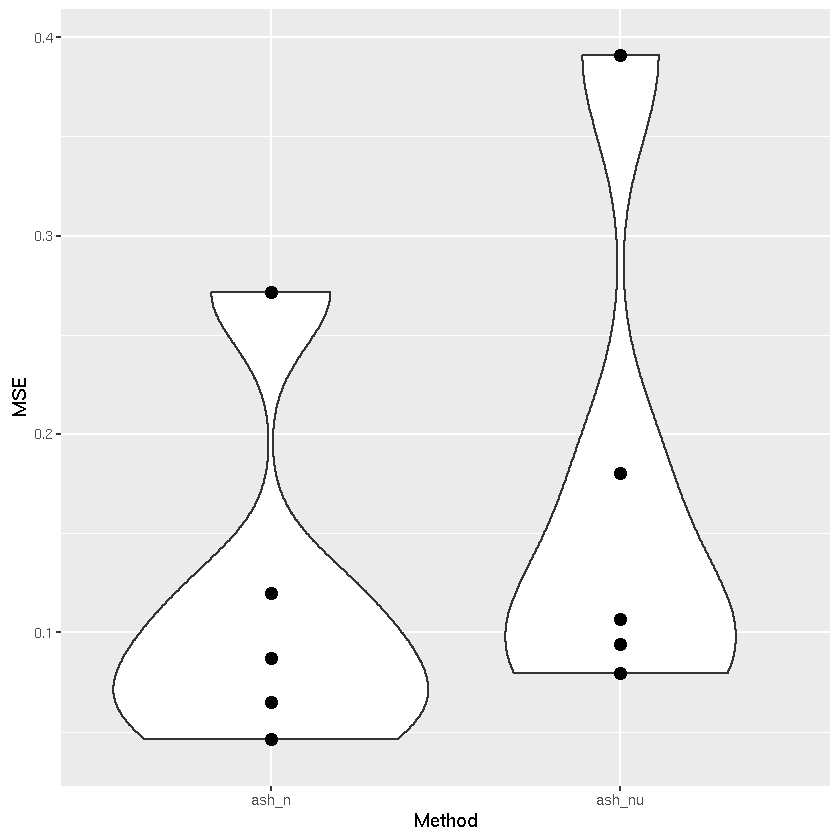

In [12]:
%use ir
dat = readRDS('ashr_pi0_1.rds')
mean(dat$An_ash_n)
mean(dat$An_ash_nu)
dat = cbind(c(dat$An_ash_n, dat$An_ash_nu), c(rep('ash_n', length(dat$An_ash_n)), 
                                             rep('ash_nu', length(dat$An_ash_nu))))
colnames(dat) = c('MSE', 'Method')
dat = data.frame(dat)
dat$MSE <- as.numeric(as.character(dat$MSE))
library(ggplot2)
p <- ggplot(data.frame(dat), aes(x=Method, y=MSE)) + 
    geom_violin() +
    geom_dotplot(binaxis='y', stackdir='center', dotsize = .5)
p